# Testing

In [190]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Load the model

In [191]:
model = keras.models.load_model('model_strat_real.h5')

Load and preprocess the Data

In [192]:
Prices_Train = pd.read_csv("csv/Prices_Train_real.csv", header=None)
Strategy_Train = pd.read_csv("csv/Strategy_Train_real.csv", header=None)
Strikes_Train = pd.read_csv("csv/Strikes_Train_real.csv", header=None)


X = pd.concat([Prices_Train,Strikes_Train],axis = 1)
Y = Strategy_Train

# Same Split as for the Training
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train.reset_index(inplace=True, drop=True)

Function that converts the data to an input of the model

In [193]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,1,1,1,1,1,0.293,0.217,0.088,0.047,...,0.634371,0.865052,0.922722,0.951557,0.980392,1.009227,1.038062,1.066897,1.095732,1.124568
1,1,1,1,1,1,1,0.304,0.280,0.258,0.206,...,0.835396,0.866337,0.897277,0.928218,0.959158,0.990099,1.021040,1.051980,1.082921,1.113861
2,1,1,1,1,1,1,0.530,0.136,0.070,0.037,...,0.724332,0.814873,0.905414,0.935595,0.965775,0.995956,1.026136,1.056317,1.086497,1.116678
3,1,1,1,1,1,1,0.372,0.163,0.112,0.066,...,0.731993,0.829592,0.927191,0.975991,1.024790,1.073590,1.122389,1.219988,1.268788,1.317587
4,1,1,1,1,1,1,0.577,0.274,0.153,0.065,...,0.638866,0.696945,0.987339,1.016378,1.045418,1.074457,1.103496,1.161575,1.219654,1.277733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,1,1,1,1,1,1,0.098,0.070,0.045,0.039,...,0.694712,0.733308,0.849093,0.887688,0.964878,1.013122,1.061366,1.109610,1.254342,1.350830
44996,1,1,1,1,1,1,0.068,0.056,0.045,0.036,...,0.717292,0.812930,0.908569,0.956389,1.004208,1.052028,1.099847,1.147666,1.243305,1.338944
44997,1,1,1,1,1,1,0.152,0.124,0.098,0.053,...,0.811425,0.843882,0.876339,0.941253,0.973710,1.006167,1.038624,1.071081,1.103538,1.135995
44998,1,1,1,1,1,1,0.135,0.121,0.066,0.044,...,0.556638,0.626218,0.974116,1.043696,1.113276,1.182856,1.252435,1.461174,1.530754,1.809073


In [194]:
def X_to_Input(X):
    K = tf.concat([np.zeros((len(X),5)),np.array(X.iloc[:,112:])],axis = 1)
    pi_minus = tf.constant(X.iloc[:,57:112])
    pi_plus  = tf.constant(X.iloc[:,1:56])
    return [K,pi_minus,pi_plus]

Function that generates outcomes of S

In [195]:
n_assets =5 
def generate_sample_S(Batch_size,Batch_S):
    S = tf.random.uniform([Batch_size,n_assets,Batch_S],0,2)
    return  S

Function that evaluates model output on S

Testing the outcomes on Several generations of S

In [196]:
def payoffs(S,K,Batch_size,Batch_S):    
    assets = S
    Calls1 = tf.nn.relu(tf.repeat(S[:,0,tf.newaxis],10,axis=1)-tf.repeat(K[:,5:15,tf.newaxis] ,Batch_S,axis = 2) )    
    Calls2 = tf.nn.relu(tf.repeat(S[:,1,tf.newaxis],10,axis=1)-tf.repeat(K[:,15:25,tf.newaxis] ,Batch_S,axis = 2) )
    Calls3 = tf.nn.relu(tf.repeat(S[:,2,tf.newaxis],10,axis=1)-tf.repeat(K[:,25:35,tf.newaxis] ,Batch_S,axis = 2) )
    Calls4 = tf.nn.relu(tf.repeat(S[:,3,tf.newaxis],10,axis=1)-tf.repeat(K[:,35:45,tf.newaxis] ,Batch_S,axis = 2))
    Calls5 = tf.nn.relu(tf.repeat(S[:,4,tf.newaxis],10,axis=1)-tf.repeat(K[:,45:55,tf.newaxis] ,Batch_S,axis = 2))
    return tf.concat([assets,Calls1,Calls2,Calls3,Calls4,Calls5],1)

In [197]:
def generate_output(X,Batch_S = 100):
    a = model(X_to_Input(X))[0]
    h_minus = model(X_to_Input(X))[1]
    h_plus = model(X_to_Input(X))[2]
    K = tf.cast(X_to_Input(X)[0],tf.float32)
    pi_minus = tf.cast(X_to_Input(X)[1],tf.float32)
    pi_plus = tf.cast(X_to_Input(X)[2],tf.float32)
    Batch_size = a.shape[0]

    S = generate_sample_S(Batch_size,Batch_S)
    nr_payoffs = 56 # Cash + 5 Stocks + 5*10 Calls 
    f = a +tf.reshape(tf.reduce_sum(h_plus*pi_plus-h_minus*pi_minus,axis = 1),(Batch_size,1))
    a_expanded =tf.repeat(a,Batch_S,axis = 1)
    strat_expanded = payoffs(S,K,Batch_size,Batch_S)*tf.repeat((h_plus-h_minus)[:,:,tf.newaxis],Batch_S,axis = 2)
    I = a_expanded+tf.reduce_sum(strat_expanded,axis = 1 )
    return I,f

In [198]:
I,f = generate_output(X_test,200)
profit = tf.reshape(I-f,-1).numpy()

In [199]:
pd.DataFrame(profit).describe()

,0
count,1000000.000000
mean,0.511423
std,0.341690
min,-0.199701
25%,0.246262
50%,0.442689
75%,0.737924
max,3.939372


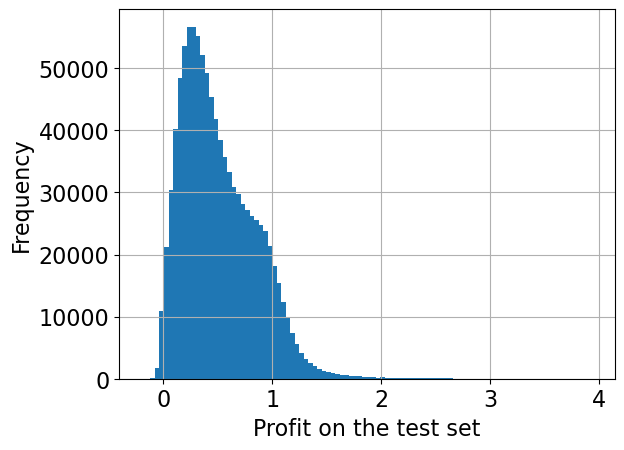

In [200]:
plt.hist(np.reshape(profit,-1),bins = 100)
plt.xlabel("Profit on the test set")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Histogram_test.pdf",bbox_inches='tight')
plt.show()



In [201]:
np.sum(profit<0)

9841